## MODELO SOCIAL - CÍENAGA AYAPEL
Acontinuación se presenta el modelo social desarrollado para la ciénaga Ayapel

In [76]:
# 1. LIBRERIAS

In [77]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 70em; }</style>"))

import numpy as np
import pandas as pd
import sys, os

from IPython.display import display
import ipywidgets as wg
from ipywidgets import interact_manual, Layout

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

wg.interact_manual.opts['manual_name'] = "Run!"
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [78]:
# 2. MODELO SOCIAL MATEMATICO

In [79]:
class ModeloSocialAyapel():
    def __init__(self, 
                 dt = 1,
                 end_time = 15,
                 n_especies = 13,
                 n_artes = 3):
        self.dt = dt
        
        self.n_especies = n_especies
        self.n_artes = n_artes
        
        self.t = np.arange(0, end_time + dt, dt)
        self.T = self.t * dt
        
        
        self.dictionary()
    
    def __call__(self,
                 Init_P     = 47_809,
                 Init_Pf    = - 73.86,
                 Init_HaPas = 106_134.91,
                 Init_HaCul = 21_625.76,
                 Init_Gan   = 147629.43908961874,
                 Init_Agr   = 21_625,
                 Init_StoPe = [ 9.061938719964985,
                                3845.247211397556,
                                78.19038150730798,
                                0.0,
                                29.433590983790985,
                                3851.119500389132,
                                3400.534461123847,
                                1765.9417796643934,
                                866.0368727031464,
                                75.8897954697032,
                                1834.3215413536536,
                                496.3935954538137,
                                1109.1454652366745]
                 
                               # [0,
                               # 3032.952552,
                               # 0,
                               # 0,
                               # 0,
                               # 9645.376285,
                               # 1372.25038,
                               # 705.0131364,
                               # 0,
                               # 0,
                               # 0,
                               # 228.9137004,
                               # 6267.513404]
                 ):
        '''
        Init_P: Poblacion inicial [Hab]
        Init_Pf: Cambio en la poblacion [Hab/anio]
        '''
        # MAIN
        t_ini = self.t[0]
        
        # SAVE DATA
        lts_p  = [Init_P]
        lts_pf = [Init_Pf]
        
        lts_pp = [np.nan]
        lts_pa = [np.nan]
        lts_pg = [np.nan]
        lts_pm = [np.nan]
        
        lts_ingG = [self.dingG_dt(0, [Init_Gan]          , self.dt)]
        lts_ingA = [self.dingA_dt(0, [Init_Agr * self.dt], self.dt)]
        lts_ingP = [np.nan]
        lts_ingM = [np.nan]
        
        lts_HaCien, lts_HaCCien = self.__HaCien()
        lts_HaPas = [Init_HaPas]
        lts_HaCul = [Init_HaCul]
        lts_StoPes = [np.array(Init_StoPe)]
        
        lts_Gan = [Init_Gan]
        lts_Agr = [Init_Agr * self.dt]
        lts_mAu = [np.nan]
        lts_des = [np.nan]
        
        # STAR
        for num, timeStep in enumerate(self.t[1:]):
            dt = timeStep - t_ini
            
            # ACTIVIDADES ECONOMICAS INDEPENDIENTES DE LA POBLACION
            ## AREAS DE PASTO [HA]
            PasHa = self.__correcData(self.RK4(lts_HaPas[-1], dt,
                                               [lts_HaCCien[num]],
                                               self.dPasHa_dt,
                                               num))
            dpas_dt = (PasHa - lts_HaPas[-1]) / dt
            lts_HaPas.append(PasHa)
            
            ## AREAS DE CULTIVO [HA]
            CulHa = self.__correcData(self.RK4(lts_HaCul[-1], dt,
                                               [lts_HaCCien[num]],
                                               self.dCulHa_dt,
                                               num))
            dCultHa_dt = (CulHa - lts_HaCul[-1]) / dt
            lts_HaCul.append(CulHa)
            
            ## g GANADERIA [CAB]
            g = min(self.__correcData(self.RK4(lts_Gan[-1], dt,
                                           [0],
                                           self.dG_dt,
                                           num)), self.dicc['Densidad ganadera cab/ha'][0] * PasHa)
            
            dg_dt = (g - lts_Gan[-1]) / dt
            lts_Gan.append(g)
            
            ## ingG INGRESOS GANADEROS [COP / dt]
            ingG = self.dingG_dt(0, [lts_Gan[-1]], dt)
            lts_ingG.append(ingG)
            
            ## a ALIMENTO [TON / ANIO]
            a = self.dAgr_dt(0, [CulHa], dt)
            lts_Agr.append(a)
            
            ## ingA INGRESOS AGRICOLAS [COP/ dt]
            ingA = self.dingA_dt(0, [lts_Agr[-1]], dt)
            lts_ingA.append(ingA)
            
            # POBLACION
            p = self.__correcData(self.RK4(lts_p[-1], dt,
                                           [lts_pf[-1]],
                                           self.dPoblacion_dt,
                                           num))
            dp_dt = (p - lts_p[-1]) / dt
            lts_p.append(p)
            
            # POBLACION FLOTANTE
            dPf_dt = self.dPobFlot_dt(dp_dt)
            lts_pf.append(dPf_dt)
            
            ## POBLACION POR OCUPACION
            pD = self.dicc['alpha 5'][-1] * p
            pg = lts_Gan[-1] * (910_000 / 28_700_000)
            pe = p - pD - pg
            
            
            pp = self.dicc['alpha 1'][-1] * pe
            #pg = self.dicc['alpha 2'][-1] * pe
            pa = self.dicc['alpha 3'][-1] * pe
            pm = self.dicc['alpha 4'][-1] * pe
            
            # print(self.dicc['alpha 1'][-1] , self.dicc['alpha 3'][-1] , self.dicc['alpha 4'][-1])
            
            # ACTIVIDADES ECONOMICAS DEPENDIENTES DE LA POBLACION
            ## p DESEMBARQUE [TON / ANIO]
            des = self.dpes_dt(0, [pp], dt)
            lts_des.append(np.minimum(lts_StoPes[-1], des))
            
            ## ingP INGRESOS DE LOS PESCADORES  [COP/dt]
            ingP = self.dIng_dt(0, [des], dt)
            lts_ingP.append(ingP)
            
            ## m MINERIA [TON / ANIO]
            mAu = self.dmin_dt(0, [pm], dt)
            lts_mAu.append(mAu)
            
            ## IngMin Ingresos mineria de oro [COP / ANIO]
            ingM = self.dIngMin(0, [lts_mAu[-1]], dt)
            lts_ingM.append(ingM)
            
            ## stpes STOCK PESQUERO [TON]
            stpes = self.__correcDataArray(self.RK4(lts_StoPes[-1], dt,
                                                   [lts_des[-1]],
                                               self.dStpes_dt,
                                               num))
            lts_StoPes.append(stpes)
            
            # SALARIO POR PERSONA
            perPes = sum(ingP) / pp
            perGan = dt * self.dicc['Salario habitante dedicado al sector Ganadera anual'][-1]
            perAgr = dt * self.dicc['Salario habitante dedicado al sector Agricola anual'][-1]
            perMin = ingM / pm
            
            # ATRACTIVIDAD SALARIAL [0 - 1]
            AtraSalaPes = perPes / (perPes + perAgr + perMin)
            AtraSalaAgr = perAgr / (perPes + perAgr + perMin)
            AtraSalaMin = perMin / (perPes + perAgr + perMin)
            
            # ATRACTIVIDAD AUTOCONSUMO
            AtraAutPes = 0.66 * self.dicc['Autoconsumo pesquero'][-1] / (self.dicc['Autoconsumo pesquero'][-1] + self.dicc['Autoconsumo ganadero'][-1] + self.dicc['Autoconsumo Agricola'][-1])
            AtraAutAgr = 0.66 * self.dicc['Autoconsumo Agricola'][-1] / (self.dicc['Autoconsumo pesquero'][-1] + self.dicc['Autoconsumo ganadero'][-1] + self.dicc['Autoconsumo Agricola'][-1])
            AtraAutMin = 0.33
            
            alpha1 = np.mean([self.dicc['beta 3 - Ponderacion autoconsumo y salario'][0] * AtraSalaPes,\
                            (1 - self.dicc['beta 3 - Ponderacion autoconsumo y salario'][0]) * AtraAutPes])
            
            alpha3 = np.mean([self.dicc['beta 3 - Ponderacion autoconsumo y salario'][0] * AtraSalaAgr,\
                            (1 - self.dicc['beta 3 - Ponderacion autoconsumo y salario'][0]) * AtraAutAgr])
            
            alpha4 = np.mean([self.dicc['beta 3 - Ponderacion autoconsumo y salario'][0] * AtraSalaMin,\
                            (1 - self.dicc['beta 3 - Ponderacion autoconsumo y salario'][0]) * AtraAutMin])
            
            # SAVE DATA
            lts_pp.append(pp)
            lts_pg.append(pg)
            lts_pa.append(pa)
            lts_pm.append(pm)
            
            
            # RELOAD DATA
            self.dicc['alpha 1'].append(alpha1 / (alpha1 + alpha3 + alpha4))
            self.dicc['alpha 3'].append(alpha3 / (alpha1 + alpha3 + alpha4))
            self.dicc['alpha 4'].append(alpha4 / (alpha1 + alpha3 + alpha4))
            
            self.dicc['Tasa cambio de pastos'].append(-0.080878)
            self.dicc['Tasa cambio de cultivos'].append(-0.06568555278519692)
            
            self.dicc['Densidad ganadera cab/ha'].append(1.2)
            
            t_ini = timeStep
        
        self.RES = pd.DataFrame()
        self.RES['Tiempo']              = list(self.t + 2005)
        
        self.RES['Poblacion_Hab']       = lts_p
        self.RES['Pob. Pesquera Hab']   = lts_pp
        self.RES['Pob. Ganadera Hab']   = lts_pg
        self.RES['Pob. Agricola Hab']   = lts_pa
        self.RES['Pob. Minera Hab']     = lts_pm
        self.RES['Pob. Flotante']       = lts_pf
        
        self.RES['Area de pasto Ha']    = lts_HaPas
        self.RES['Area de cultivos Ha'] = lts_HaCul
        self.RES['Area de Cienaga Ha'] = lts_HaCien
        self.RES['Stock pesquero Ton']  = lts_StoPes
        
        self.RES['Cantidad de ganado Cab']         = lts_Gan
        self.RES['Alimento cosechado Ton/dt']      = lts_Agr
        self.RES['Desembarcos por especie Ton/dt'] = lts_des
        self.RES['Extraccion de oro Ton/dt']       = lts_mAu
        
        self.RES['Ingresos ganaderos COP/dt'] = lts_ingG
        self.RES['Ingresos Agricolas COP/dt'] = lts_ingA
        self.RES['Ingresos Pesqueroa COP/dt'] = lts_ingP
        self.RES['Ingresos Mineros COP/dt']   = lts_ingM
        
        self.RES = self.RES.set_index('Tiempo')
    
    # MODELOS
    def dPobFlot_dt(self, dp_dt):
        dPobFlot_dt = dp_dt * self.dicc['beta 4 - Migraciones'][0]
        return(dPobFlot_dt)
    
    def __HaCien(self):
        alpha = 0.7 * np.modf(self.t)[0] * 2 * np.pi
        HaCien = 100 * (-80 * np.cos(1.5 * alpha + 4.6) + 130)
        
        HaPlay = np.diff(HaCien, 1) / self.dt
        lts = [0]
        lts = lts + list(HaPlay)
        return(list(HaCien), lts)
    
    def dIngMin(self, Init, mAu, dt):
        dIngMin = mAu[0] * 10 ** 6 * self.dicc['Precio por gramo de oro [COP/g]'][-1] \
            * (1 - self.dicc['Porcentaje de inversion en mineria'][-1])
        return(dIngMin)
    
    def dmin_dt (self, Init, pm, dt):
        dmin_dt = dt * pm[0] * self.dicc['Productividad de los mineros de oro Ton/Hab*anio'][-1]
        return (dmin_dt)
    
    def dIng_dt (self, Init, fs, dt):
        dIng_dt = fs[0] * np.array(self.dicc['Precio por tonelada de cada especie de pez COP/TON']) \
            * (1 - self.dicc['Autoconsumo pesquero'][0])
        return(dIng_dt)
    
    def dpes_dt (self, Init, pp, dt):
        des = dt * pp[0] * np.array(self.dicc['Productividad de cada especie pesquera TON/hab * anio']) \
            * (self.dicc['Numero de meses con veda'][0] / 12.)
        return (des)
    
    def dStpes_dt(self, Init, fs, dt):
        dStpes_dt = Init * np.array(self.dicc['Tasa de cambio del stock pesquero %/anio']) - fs[0]
        return(dStpes_dt)
    
    def dingA_dt(self, Init, fs, dt):
        dingA_dt = self.dicc['Precio de los alimentos COP/TON'][-1] * fs[0] * \
            (1 - self.dicc['Inversion realizada en los cultivos %'][-1])
        return(dingA_dt)
    
    def dingG_dt(self, Init, fs, dt):
        dingG_dt = dt * fs[0] * self.dicc['Porc. Sacrificios %/anio'][-1] * \
        (1 - self.dicc['Autoconsumo ganadero'][-1]) * self.dicc['Precio por cabezas de ganado COP/Cab'][-1]
        return(dingG_dt)
    
    
    def dAgr_dt(self, Init, CulHa, dt):
        dAgr_dt = dt * self.dicc['Productividad de los cultivos Ton/Ha*anio'][-1] *\
            CulHa[0] * (1 - self.dicc['Pocentaje de cultivo perdido al anio'][-1] * \
                        (1 - self.dicc['Autoconsumo Agricola'][-1]) * self.dt)
        return(dAgr_dt)
    
    def dG_dt(self, Init, fs, num):
        dg_dt = Init * (self.dicc['Tasa de natalidad neta %/anio'][-1] - self.dicc['Porc. Sacrificios %/anio'][-1])
        return(dg_dt)
    
    def dPoblacion_dt(self, Init, dpf_dt, num):
        dp_dt = Init * (self.dicc['Tasa de natalidad'][num] - \
                        self.dicc['Tasa de mortalidad'][num]) + dpf_dt[0]
        return(dp_dt)
    
    def dPasHa_dt(self, Init, fs, num):
        return(Init * self.dicc['Tasa cambio de pastos'][num] - self.dicc['beta 1: Efecto Cienaga - Pastos'][0] * fs[0])
    
    def dCulHa_dt(self, Init, fs, num):
        return(Init * self.dicc['Tasa cambio de cultivos'][num] - self.dicc['beta 2: Efecto Cienaga - Cultivos'][0] * fs[0])
    
    # OTHERS
    @staticmethod
    def RK4(init, h, fs, fun, num):
        subStep = 4
        h_int = h / subStep
        for ii in list(range(subStep)):
            k1 = fun(init          , fs, num)
            k2 = fun(init + k1 / 2., fs, num)
            k3 = fun(init + k2 / 2., fs, num)
            k4 = fun(init + k3     , fs, num)
            m = h_int * (k1 + 2 * k2 + 2 * k3 + k4) / 6.
            init = init + m
        return(init)
    
    @staticmethod
    def __correcData(num):
        return(0 if num <= 0 else num)
    
    @staticmethod
    def __correcDataArray(data):
        data[data <= 0] = 0
        return(data)
    
    def dictionary(self,
                   Tnata = 5.02 / 1000,
                   Tmort = 5.31 / 1000,
                   DenGa = 1.2,
                   TCambCult = -0.15003684,
                   TCambPast = 0.25155885,
                   ProdAgr   = 6.38,
                   PorSac    = 0.22924705,
                   PorPerd   = 0.0,
                   TnataVaca = 0.16658533,
                   PorcAutoG = 0.04,
                   PorAutoA  = 0.05,
                   PorAutoP  = 0.125,
                   CopCult_ton = 2_177_136.22,
                   Cop_Cab = 1_900_000,
                   SalAgri = 6_000_000,
                   SalGana = 6_500_000,
                   InvCult = 0.4,
                   ProdMinAu = 0.000045,
                   Cop_gAu = 159_712.82,
                   InvMAu = 0.1,
                   NumMesVeda = 3
                   ):
        '''
        DEFAULT
        Artes de pesca:
            1) Atarralla
            2) Palagre
            3) Redes de enmalle
        Especies- Taxon:
            1) Ageneiosus pardalis
            2) Caquetaia kraussii
            3) Centrochir crocodili
            4) Curimata mivartii
            5) Cynopotamus magdalenae
            6) Cyphocharax magdalenae
            7) Hoplias malabaricus
            8) Megaleporinus muyscorum
            9) Pimelodus grosskopfii
            10) Prochilodus magdalenae
            11) Sorubim cuspicaudus
            12) Trachelyopterus insignis
            13) Triportheus magdalenae

        '''
        self.dicc = {
            'Tasa de natalidad'       : np.ones(len(self.t)) * Tnata, 
            'Tasa de mortalidad'      : np.ones(len(self.t)) * Tmort,
            
            'Tasa cambio de pastos'   : [TCambPast],
            'Tasa cambio de cultivos' : [TCambCult],
            
            'Densidad ganadera cab/ha': [DenGa],
            
            'Productividad de los cultivos Ton/Ha*anio' : [ProdAgr],
            'Pocentaje de cultivo perdido al anio': [PorPerd],
            'Autoconsumo Agricola': [PorAutoA],
            
            'Productividad de los mineros de oro g/Hab*anio' : [ProdMinAu * 10 **6],
            'Productividad de los mineros de oro Ton/Hab*anio' : [ProdMinAu],
            
            'Porc. Sacrificios %/anio' : [PorSac],
            'Tasa de natalidad neta %/anio': [TnataVaca],
            'Autoconsumo ganadero': [PorcAutoG],
            
            'Autoconsumo pesquero': [PorAutoP],
            'Numero de meses con veda': [NumMesVeda],
            
            'Precio de los alimentos COP/TON':[CopCult_ton],
            'Precio por cabezas de ganado COP/Cab': [Cop_Cab],
            'Inversion realizada en los cultivos %': [InvCult],
            'Precio por gramo de oro [COP/g]':[Cop_gAu],
            'Porcentaje de inversion en mineria':[InvMAu],
            
            'Salario habitante dedicado al sector Agricola anual': [SalAgri],
            'Salario habitante dedicado al sector Ganadera anual' : [SalGana],
            
            
            # Valores iniciales del porcentaje de personas dedicadas a una actividad
            'alpha 1':[0.36154979242846536],
            'alpha 3':[0.2209155620491758],
            'alpha 4':[0.4175346455223588],
            
            # Tasa de desempleo
            'alpha 5':[0.10],
            
            # Valores del modelo
            'beta 1: Efecto Cienaga - Pastos' : [0.1],
            'beta 2: Efecto Cienaga - Cultivos' : [0.1],
            'beta 3 - Ponderacion autoconsumo y salario': [0.0442],
            'beta 4 - Migraciones' : [0.75396578]
            }
        
        if (self.n_artes == 3) & (self.n_especies == 13):
            self.dicc['Tasa de cambio del stock pesquero %/anio'] = [0.5549280282859823,
                                                                0.5717809571227911,
                                                                0.01974577623220387,
                                                                0.0,
                                                                0.08823543225555693,
                                                                0.37075062807127174,
                                                                0.2990265692627185,
                                                                -0.09440107293788676,
                                                                0.47106806613232893,
                                                                0.7029286011187359,
                                                                -0.11748104241925343,
                                                                0.7303766180639671,
                                                                0.18338698762111222]

            self.dicc['Productividad de cada especie pesquera TON/hab * anio'] = [0.0019006531569610557,
                                                                            0.49995716245404914,
                                                                            2.944722953245416e-05,
                                                                            0.0,
                                                                            0.001088124138339197,
                                                                            0.3881265885659103,
                                                                            0.22531681356060404,
                                                                            0.005318643499683985,
                                                                            0.13581912209566935,
                                                                            0.007932236103466253,
                                                                            0.01830604351845296,
                                                                            0.09601055481299989,
                                                                            0.0010663850915061668]
            
            self.dicc['Precio por tonelada de cada especie de pez COP/TON'] = [2_500_000,
                                                                               2_500_000,
                                                                               2_500_000,
                                                                               2_500_000,
                                                                               2_500_000,
                                                                               2_500_000,
                                                                               2_500_000,
                                                                               2_500_000,
                                                                               2_500_000,
                                                                               2_500_000,
                                                                               2_500_000,
                                                                               2_500_000,
                                                                               2_500_000]
            
            self.dicc['Porcentaje de desembarco por arte de pesca'] = [0.18, 0.02, 0.81]
        else:
            self.dicc['Tasa de cambio del stock pesquero %/anio'] = list(np.zeros[self.n_especies])
            self.dicc['Productividad de cada especie pesquera TON/hab * anio'] = list(np.zeros[self.n_especies])
            self.dicc['Porcentaje de desembarco por arte de pesca'] = list(np.zeros[self.n_artes])

In [80]:
def PlotFigures(res1, res2):
    n_especies = len(res1['Stock pesquero Ton'].iloc[0])

    fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                           subplot_titles=("Resultados simulados", "Resultados escenario"))

    # COL 1
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Poblacion_Hab'],
                            name='Población total',
                            line=dict(color='#6D545D'),
                            legendgroup='group1'), 1, 1)
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Pob. Pesquera Hab'],
                            name='Población de pescadores',
                            line=dict(color='#756D54'),
                            legendgroup='group2'), 1, 1)
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Pob. Ganadera Hab'],
                            name='Población dedicada a la ganaderia',
                            line=dict(color='#8B9556'),
                            legendgroup='group3'), 1, 1)
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Pob. Agricola Hab'],
                            name='Población dedicada a la agricultura',
                            line=dict(color='#ABB557'),
                            legendgroup='group4'), 1, 1)
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Pob. Minera Hab'],
                            name='Población dedicada a la mineria',
                            line=dict(color='#BED558'),
                            legendgroup='group5'), 1, 1)
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Pob. Flotante'],
                            name='Población flotante',
                            line=dict(color='#C4D967'),
                            legendgroup='group6'), 1, 1)

    # COL 2
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Poblacion_Hab'],
                            name='Población total',
                            legendgroup='group1',
                            line=dict(color='#6D545D'),
                            showlegend=False), 1, 2)
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Pob. Pesquera Hab'],
                            name='Población de pescadores',
                            line=dict(color='#756D54'),
                            legendgroup='group2',
                            showlegend=False), 1, 2)
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Pob. Ganadera Hab'],
                            name='Población dedicada a la ganaderia',
                            legendgroup='group3',
                            line=dict(color='#8B9556'),
                            showlegend=False), 1, 2)
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Pob. Agricola Hab'],
                            name='Población dedicada a la agricultura',
                            line=dict(color='#ABB557'),
                            legendgroup='group4',
                            showlegend=False), 1, 2)
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Pob. Minera Hab'],
                            name='Población dedicada a la mineria',
                            line=dict(color='#BED558'),
                            legendgroup='group5',
                            showlegend=False), 1, 2)
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Pob. Flotante'],
                            name='Población flotante',
                            line=dict(color='#C4D967'),
                            legendgroup='group6',
                            showlegend=False), 1, 2)

    fig.update_layout(title_text="Población")
    fig['layout']['yaxis']['title']='Hab'
    fig['layout']['xaxis']['title']='Año'
    fig['layout']['xaxis2']['title']='Año'

    fig.show()

    ################### AREAS
    fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                           subplot_titles=("Resultados simulados", "Resultados escenario"))

    # COL 1
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Area de pasto Ha'],
                            name='Área de pastos',
                            line=dict(color='#6D545D'),
                            legendgroup='group1'), 1, 1)
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Area de cultivos Ha'],
                            name='Area de cultivos Ha',
                            line=dict(color='#756D54'),
                            legendgroup='group2'), 1, 1)
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Area de Cienaga Ha'],
                            name='Área de Cienaga',
                            line=dict(color='#8B9556'),
                            legendgroup='group3'), 1, 1)


    # COL 2
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Area de pasto Ha'],
                            name='Área de pastos',
                            legendgroup='group1',
                            line=dict(color='#6D545D'),
                            showlegend=False), 1, 2)
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Area de cultivos Ha'],
                            name='Área de cultivos Ha',
                            line=dict(color='#756D54'),
                            legendgroup='group2',
                            showlegend=False), 1, 2)
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Area de Cienaga Ha'],
                            name='Área de Cienaga',
                            legendgroup='group3',
                            line=dict(color='#8B9556'),
                            showlegend=False), 1, 2)

    fig.update_layout(title_text="Área")
    fig['layout']['yaxis']['title']='Ha'
    fig['layout']['xaxis']['title']='Año'
    fig['layout']['xaxis2']['title']='Año'

    fig.show()

    ################### SERVICIO ECOSISTEMICO
    fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                           subplot_titles=("Resultados simulados", "Resultados escenario"))

    # COL 1
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Alimento cosechado Ton/dt'],
                            name='Alimento cosechado',
                            line=dict(color='#6D545D'),
                            mode='markers',
                            legendgroup='group1'), 1, 1)


    # COL 2
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Alimento cosechado Ton/dt'],
                            name='Alimento cosechado',
                            legendgroup='group1',
                            line=dict(color='#6D545D'),
                            mode='markers',
                            showlegend=False), 1, 2)


    fig.update_layout(title_text="Extracciones")
    fig['layout']['yaxis']['title']='Ton/año'
    fig['layout']['xaxis']['title']='Año'
    fig['layout']['xaxis2']['title']='Año'

    fig.show()
    
    fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                           subplot_titles=("Resultados simulados", "Resultados escenario"))

    # COL 1
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Extraccion de oro Ton/dt'] * 10**6,
                            name='Extraccion de oro',
                            line=dict(color='#C4D967'),
                            mode='markers',
                            legendgroup='group2'), 1, 1)


    # COL 2
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Extraccion de oro Ton/dt'] * 10**6,
                            name='Extraccion de oro',
                            line=dict(color='#C4D967'),
                            mode='markers',
                            legendgroup='group2',
                            showlegend=False), 1, 2)


    fig.update_layout(title_text="Extracciones")
    fig['layout']['yaxis']['title']='g/año'
    fig['layout']['xaxis']['title']='Año'
    fig['layout']['xaxis2']['title']='Año'

    fig.show()

    ###################### INGRESOS

    fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                           subplot_titles=("Resultados simulados", "Resultados escenario"))

    # COL 1
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Ingresos ganaderos COP/dt'],
                            name='Ingresos ganaderos',
                            mode='markers',
                            line=dict(color='#6D545D'),
                            legendgroup='group1'), 1, 1)
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Ingresos Agricolas COP/dt'],
                            name='Ingresos Agricolas',
                            mode='markers',
                            line=dict(color='#756D54'),
                            legendgroup='group2'), 1, 1)
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Ingresos Pesqueroa COP/dt'],
                            name='Ingresos Pesqueros',
                            mode='markers',
                            line=dict(color='#8B9556'),
                            legendgroup='group3'), 1, 1)
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Ingresos Mineros COP/dt'],
                            name='Ingresos Mineros',
                            mode='markers',
                            line=dict(color='#ABB557'),
                            legendgroup='group4'), 1, 1)

    # COL 2
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Ingresos ganaderos COP/dt'],
                            name='Ingresos ganaderos COP/dt',
                            legendgroup='group1',
                            mode='markers',
                            line=dict(color='#6D545D'),
                            showlegend=False), 1, 2)
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Ingresos Agricolas COP/dt'],
                            name='Ingresos Agricolas COP/dt',
                            line=dict(color='#756D54'),
                            legendgroup='group2',
                            mode='markers',
                            showlegend=False), 1, 2)
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Ingresos Pesqueroa COP/dt'],
                            name='Ingresos Pesqueroa',
                            mode='markers',
                            legendgroup='group3',
                            line=dict(color='#8B9556'),
                            showlegend=False), 1, 2)
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Ingresos Mineros COP/dt'],
                            name='Ingresos Mineros COP/dt',
                            mode='markers',
                            line=dict(color='#ABB557'),
                            legendgroup='group4',
                            showlegend=False), 1, 2)

    fig.update_layout(title_text="INGRESOS")
    fig['layout']['yaxis']['title']='COP/año'
    fig['layout']['xaxis']['title']='Año'
    fig['layout']['xaxis2']['title']='Año'

    fig.show()

    ###########################
    colors = ['#C0C0C0', 
            '#808080', 
            '#800000', 
            '#808000',
            '#00FF00', 
            '#00FFFF', 
            '#008080', 
            '#000080', 
            '#FF00FF',
            '#800080', 
            '#CD5C5C', 
            '#F08080', 
            '#FA8072', 
            '#E9967A', 
            '#FFA07A', 
            '#FF7F50',
            '#FF6347',
            '#FF4500',
            '#FFD700',
            '#FFA500',
            '#FF8C00']

    ########################### STOCK PESQUERO

    fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                           subplot_titles=("Resultados simulados", "Resultados escenario"))

    for jj in range(n_especies):

        fig.add_trace(go.Scatter(x = res1.index,
                                 y = [res1['Stock pesquero Ton'].iloc[ii][jj] for ii in range(len(res1))],
                                name='Stock pesquero - especie ' + str(jj),
                                mode='markers',
                                line=dict(color=colors[jj]),
                                legendgroup='group'+str(jj)), 1, 1)

        fig.add_trace(go.Scatter(x = res2.index,
                                 y = [res2['Stock pesquero Ton'].iloc[ii][jj] for ii in range(len(res2))],
                                name='Stock pesquero - especie ' + str(jj),
                                mode='markers',
                                line=dict(color=colors[jj]),
                                legendgroup='group'+str(jj),
                                showlegend=False), 1, 2)

    fig.update_layout(title_text="Stock pesquero")
    fig['layout']['yaxis']['title']='TON'
    fig['layout']['xaxis']['title']='Año'
    fig['layout']['xaxis2']['title']='Año'

    fig.show()

    ########################### DESEMBARCO PESQUERO

    fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                           subplot_titles=("Resultados simulados", "Resultados escenario"))

    for jj in range(n_especies):

        fig.add_trace(go.Scatter(x = res1.index,
                                 y = [res1['Desembarcos por especie Ton/dt'].iloc[ii][jj] for ii in range(1, len(res1))],
                                name='Desembarcos por especie - ' + str(jj),
                                mode='markers',
                                line=dict(color=colors[jj]),
                                legendgroup='group'+str(jj)), 1, 1)

        fig.add_trace(go.Scatter(x = res2.index,
                                 y = [res2['Desembarcos por especie Ton/dt'].iloc[ii][jj] for ii in range(1, len(res2))],
                                name='Desembarcos por especie - ' + str(jj),
                                mode='markers',
                                line=dict(color=colors[jj]),
                                legendgroup='group'+str(jj),
                                showlegend=False), 1, 2)

    fig.update_layout(title_text="Desembarco pesquero")
    fig['layout']['yaxis']['title']='Ton/Año'
    fig['layout']['xaxis']['title']='Año'
    fig['layout']['xaxis2']['title']='Año'

    fig.show()

    ########################### CAPITAL PESQUERO

    fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                           subplot_titles=("Resultados simulados", "Resultados escenario"))

    for jj in range(n_especies):

        fig.add_trace(go.Scatter(x = res1.index,
                                 y = [res1['Ingresos Pesqueroa COP/dt'].iloc[ii][jj] for ii in range(1, len(res1))],
                                name='Ingresos Pesqueros - ' + str(jj),
                                mode='markers',
                                line=dict(color=colors[jj]),
                                legendgroup='group'+str(jj)), 1, 1)

        fig.add_trace(go.Scatter(x = res2.index,
                                 y = [res2['Ingresos Pesqueroa COP/dt'].iloc[ii][jj] for ii in range(1, len(res2))],
                                name='Ingresos Pesqueros - ' + str(jj),
                                mode='markers',
                                line=dict(color=colors[jj]),
                                legendgroup='group'+str(jj),
                                showlegend=False), 1, 2)

    fig.update_layout(title_text="Ingresos pesquero")
    fig['layout']['yaxis']['title']='COP/Año'
    fig['layout']['xaxis']['title']='Año'
    fig['layout']['xaxis2']['title']='Año'

    fig.show()

# MODELO SICIAL - CIÉNAGA AYAPEL

En este notebook se presenta el modelo social generado a partir de dinamica de sistemas para el comportamiento de las principales variables de la ciénaga Ayapel. Este se basa en las relaciones causales identificadas pare el sector de estudio, las cuales se observan en el diagrama de forrester presentado a continuación.

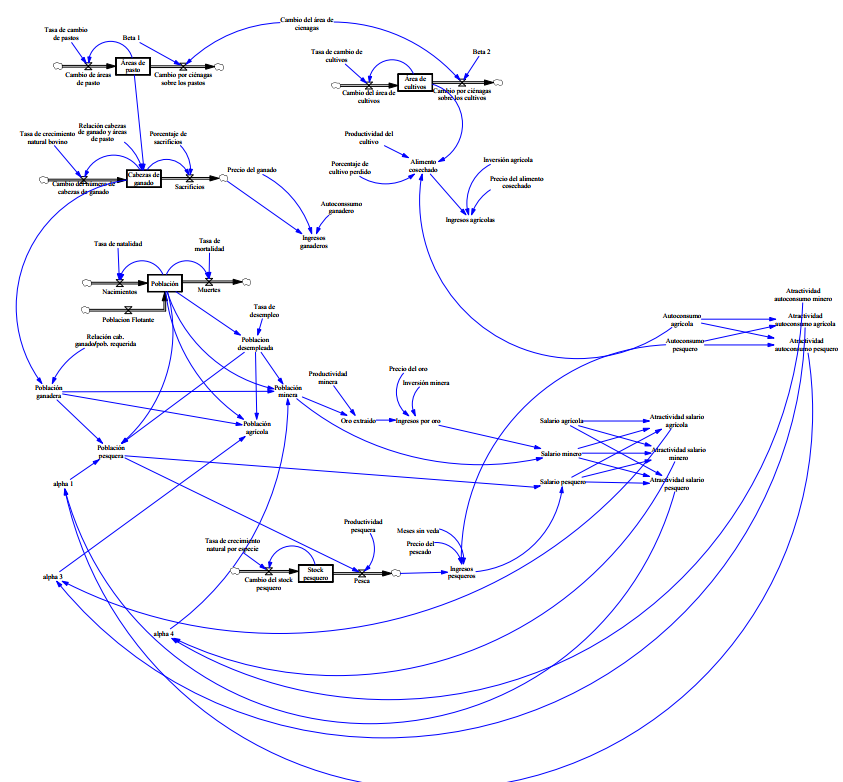

*Autoria propia*

In [81]:
# RUN MODEL
def run(P_Tcul, P_TCreGan, NVeda, P_ProdPes, P_ProfMinAu, long_model):
    
    global res1, res2
    
    long_model  = long_model
    P_Tcul      = P_Tcul / 100.
    P_TCreGan   = P_TCreGan / 100.
    NVeda       = NVeda
    P_ProdPes   = P_ProdPes / 100.
    P_ProfMinAu = P_ProfMinAu / 100.
    
    # REAL VALUES - SIMULATION
    ProdPes = [0.0019006531569610557,
               0.49995716245404914,
               2.944722953245416e-05,
               0.0,
               0.001088124138339197,
               0.3881265885659103,
               0.22531681356060404,
               0.005318643499683985,
               0.13581912209566935,
               0.007932236103466253,
               0.01830604351845296,
               0.09601055481299989,
               0.0010663850915061668]
    
    T_Pasto   = 0.2515588533719049
    T_Cultivo = 0.15003683540465276
    T_CreGand = 0.16658532617582214
    ProdMinAu = 4.5163118587807896e-05
    
    model = ModeloSocialAyapel(end_time = long_model)
    model()
    res1 = model.RES.copy()
    del(model)
    
    # SCENARY RESULTS
    model = ModeloSocialAyapel(end_time = long_model)
    
    model.dicc['Tasa cambio de cultivos'] = [model.dicc['Tasa cambio de cultivos'][0] * (1 + P_Tcul)]
    model.dicc['Tasa de natalidad neta %/anio'] = [model.dicc['Tasa de natalidad neta %/anio'][0] * (1 + P_TCreGan)]
    model.dicc['Numero de meses con veda'] = [NVeda]
    model.dicc['Productividad de cada especie pesquera TON/hab * anio'] = list(np.array(model.dicc['Productividad de cada especie pesquera TON/hab * anio']) * (1 + P_ProdPes))
    
    model.dicc['Productividad de los mineros de oro g/Hab*anio']   = [model.dicc['Productividad de los mineros de oro g/Hab*anio'][0] * 10 **6 * (1 + P_ProfMinAu)],
    model.dicc['Productividad de los mineros de oro Ton/Hab*anio'] = [model.dicc['Productividad de los mineros de oro Ton/Hab*anio'][0] * (1 + P_ProfMinAu)]
    model.dicc['Tasa cambio de pastos'] = [model.dicc['Tasa cambio de pastos'][0] * (1 + P_ProfMinAu)]
    
    model()
    res2 = model.RES.copy()
    
    # PLOT RESULTS()
    PlotFigures(res1, res2)
    return 0

In [82]:
# CARGAR VALORES POR DEFECTO PARA EL MODELO

A continuación, se presentan los resultados obtenidos por medio de la calibración del modelo con los datos observados, denominado Resultados simulados y los resultados obtenidos a partir del cambio de los parámetros mostrados Resultados escenario. Los resultados por defecto mostrados como Resultados escenario, corresponden a los mismos parámetros usados para obtener los Resultados simulados.

Para correr el escenario con los nuevos parámetros es necesario precionar el boton "Run!".

Para cambiar otro parámetro se debe hacer a partir del código, en el sector denominado "piece of code"

In [83]:
# BUILD APP

In [84]:
# APP - DATOS REALES

ilong_model=wg.IntText(value=50,
                       description='Años a modelar:',
                       disabled=False, 
                       style={'description_width': 'initial'}, layout=Layout(width='90%'))

iP_Tcul = wg.IntSlider(value=0,
                        min=-100,
                        max=200,
                        description='Porcentaje de cambio de la tasa de cultivo:',
                        continuous_update=False,
                        orientation='horizontal',
                        readout=True,
                        readout_format='.0f',
                        style={'description_width': 'initial'}, layout=Layout(width='90%'))
iP_TCreGan = wg.IntSlider(value=0,
                        min=-100,
                        max=200,
                        description='Porcentaje de cambio de la tasa de crecimiento ganadero:',
                        continuous_update=False,
                        orientation='horizontal',
                        readout=True,
                        readout_format='.0f',
                        style={'description_width': 'initial'}, layout=Layout(width='90%'))
iNVeda = wg.IntSlider(value=3,
                        min=0,
                        max=12,
                        description='Meses sin veda:',
                        continuous_update=False,
                        orientation='horizontal',
                        readout=True,
                        readout_format='.0f',
                        style={'description_width': 'initial'}, layout=Layout(width='90%'))
iP_ProdPes = wg.IntSlider(value=0,
                        min=-100,
                        max=200,
                        description='Porcentaje de cambio de la productividad pesquera:',
                        continuous_update=False,
                        orientation='horizontal',
                        readout=True,
                        readout_format='.0f',
                        style={'description_width': 'initial'}, layout=Layout(width='90%'))
iP_ProfMinAu = wg.IntSlider(value=0,
                        min=-100,
                        max=200,
                        description='Porcentaje de cambio de la productividad minera:',
                        continuous_update=False,
                        orientation='horizontal',
                        readout=True,
                        readout_format='.0f',
                        style={'description_width': 'initial'}, layout=Layout(width='90%'))

#### SIMULACIÓN
A continuación, se ejecuta el modelo con los valores simulados y el modelo con los valores seleccionados para el escenario

In [85]:
# RUN INTERACT
wg.interact_manual(run, P_Tcul=iP_Tcul, P_TCreGan=iP_TCreGan, NVeda=iNVeda, P_ProdPes=iP_ProdPes, P_ProfMinAu=iP_ProfMinAu, long_model=ilong_model)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Porcentaje de cambio de la tasa…

<function __main__.run(P_Tcul, P_TCreGan, NVeda, P_ProdPes, P_ProfMinAu, long_model)>